In [1]:
import numpy as np
import soundfile as sf
from IPython.display import Audio
import matplotlib.pyplot as plt
from scipy import signal as sig

In [2]:
# Wave settings
sr = 48000
duration = 4
phase = 0
num_overtones = 30
a = 220
b = 330

In [64]:
def find_peaks(fft_signal,fs):
    th=np.max(np.abs(fft_signal))/10
    frequencies_double = sig.find_peaks(np.abs(fft_signal),threshold=th)[0]
    frequencies = frequencies_double[0:len(frequencies_double)//2]*fs/len(fft_signal)
    
    return frequencies

In [4]:
def plot_fft(x,st=0,en=sr,together='true'):
    frequency = np.arange(len(x)) * sr/len(x)
    if (together == 'false'):
        plt.figure()
    plt.plot(frequency,x)
    plt.xlim([st,en])
    plt.xlabel('Frequency (Hz)')
    plt.title('FFT ')
    return

In [5]:
def find_peaks_cwt(fft_signal,fs):
    frequencies_double = sig.find_peaks_cwt(np.abs(fft_signal),threshold=1000)[0]
    frequencies = frequencies_double[0:len(frequencies_double)//2]*fs/len(fft_signal)
    return frequencies

In [6]:
def filter_by_scale(signal, key, key_type, gain, fs):
    
    # Get the FFT of the signal and make a duplicate to filter
    fft_signal = np.fft.fft(signal)
    filtered_fft = fft_signal
    
    # Find the peaks in the FFT
    frequencies = find_peaks(fft_signal,fs)
    if (len(frequencies) >= fs/300):
        raise Exception('too much noise or something, frequencies too long')
    
    # Create empty array for transposed frequencies
    frequencies_transposed = np.zeros(len(frequencies))
    gain = 1
    
    # Transpose the frequencies in frequencies
    for i in range (0,len(frequencies)):
    
        # Transpose based on specified key type
        if (key_type == 'chromatic'):
            frequencies_transposed[i] = find_nearest(key_signature_chromatic(key),frequencies[i])
        elif (key_type == 'major'):
            frequencies_transposed[i] = find_nearest(key_signature_major(key),frequencies[i])
        elif (key_type == 'minor'):
            frequencies_transposed[i] = find_nearest(key_signature_minor(key),frequencies[i])
        elif (key_type == 'pentatonic'):
            frequencies_transposed[i] = find_nearest(key_signature_pentatonic(key),frequencies[i])
        elif (key_type == 'major triad'):
            frequencies_transposed[i] = find_nearest(key_signature_major_triad(key),frequencies[i])
            

        if (frequencies[i] != frequencies_transposed[i]):
            
            freq_band1 = filtered_fft[sample(signal,frequencies[i],fs)[0]-2:sample(signal,frequencies[i],fs)[0]+2]
            freq_band2 = filtered_fft[sample(signal,frequencies[i],fs)[1]-2:sample(signal,frequencies[i],fs)[1]+2]
            
#             if (i>1 & i%2==0):
#                 ref = np.abs(filtered_fft[sample(signal,frequencies[i],fs)[0]])
#                 gain = 3
#             else:
#                 gain = 1
            
            # Add in the transposed frequency (scaled amplitude)
            filtered_fft[sample(signal,frequencies_transposed[i],fs)[0]-2:sample(signal,frequencies_transposed[i],fs)[0]+2] \
                = freq_band1 * gain
            
            filtered_fft[sample(signal,frequencies_transposed[i],fs)[1]-2:sample(signal,frequencies_transposed[i],fs)[1]+2] \
                = freq_band2 * gain

            # Remove the original frequency
            filtered_fft[sample(signal,frequencies[i],fs)[0]-2:sample(signal,frequencies[i],fs)[0]+2] = 0
            filtered_fft[sample(signal,frequencies[i],fs)[1]-2:sample(signal,frequencies[i],fs)[1]+2] = 0
    
    
    # Inverse FFT the filtered FFT
    filtered_signal = np.real(np.fft.ifft(filtered_fft))
    
    return filtered_signal,filtered_fft

In [7]:
def filter_by_scale2(fft, key, key_type, gain, fs):
    
    # Dupilcate the frame's fft to filter
    filtered_fft = fft
    
    # Find the peaks in the FFT
    frequencies = find_peaks(fft,fs)
    if (len(frequencies) >= fs/1000):
        raise Exception('things have gone awry')
    
    # Create empty array for transposed frequencies
    frequencies_transposed = np.zeros(len(frequencies))
    
    # Transpose the frequencies in frequencies
    for i in range (0,len(frequencies)):
    
        # Transpose based on specified key type
        if (key_type == 'chromatic'):
            frequencies_transposed[i] = find_nearest(key_signature_chromatic(key),frequencies[i])
        elif (key_type == 'major'):
            frequencies_transposed[i] = find_nearest(key_signature_major(key),frequencies[i])
        elif (key_type == 'minor'):
            frequencies_transposed[i] = find_nearest(key_signature_minor(key),frequencies[i])
        elif (key_type == 'pentatonic'):
            frequencies_transposed[i] = find_nearest(key_signature_pentatonic(key),frequencies[i])
        elif (key_type == 'major triad'):
            frequencies_transposed[i] = find_nearest(key_signature_major_triad(key),frequencies[i])
        

        if (frequencies[i] != frequencies_transposed[i]):
        
            # Add in the transposed frequency (same amplitude as the original)
            filtered_fft[sample(fft,frequencies_transposed[i],fs)[0]] \
                = filtered_fft[sample(fft,frequencies[i],fs)[0]]
            filtered_fft[sample(fft,frequencies_transposed[i],fs)[1]] \
                = filtered_fft[sample(fft,frequencies[i],fs)[1]]
            
            
            # Remove the original frequency
            filtered_fft[sample(fft,frequencies[i],fs)[0]:sample(fft,frequencies[i],fs)[0]] = 0
            filtered_fft[sample(fft,frequencies[i],fs)[1]:sample(fft,frequencies[i],fs)[1]] = 0
    
    
    # Inverse FFT the filtered FFT
    filtered_signal = np.real(np.fft.ifft(filtered_fft))
        
    return filtered_signal,filtered_fft

In [61]:
def filter_by_scale3(signal, key, key_type, gain, fs):
    
    # Get the FFT of the signal and make a duplicate to filter
    fft_signal = np.fft.fft(signal)
    filtered_fft = fft_signal
    
    # Find the peaks in the FFT
    frequencies = find_peaks(fft_signal,fs)
    if (len(frequencies) >= fs/300):
        raise Exception('too much noise or something, frequencies length', len(frequencies))
    
    # Create empty array for transposed frequencies
    frequencies_transposed = np.zeros(len(frequencies))
    gain = 1
    
    # Transpose the frequencies in frequencies
    for i in range (0,len(frequencies)):
    
        # Create transposed array of prominent frequencies based on specified key type
        if (key_type == 'chromatic'):
            frequencies_transposed[i] = find_nearest(key_signature_chromatic(key),frequencies[i])
        elif (key_type == 'major'):
            frequencies_transposed[i] = find_nearest(key_signature_major(key),frequencies[i])
        elif (key_type == 'minor'):
            frequencies_transposed[i] = find_nearest(key_signature_minor(key),frequencies[i])
        elif (key_type == 'pentatonic'):
            frequencies_transposed[i] = find_nearest(key_signature_pentatonic(key),frequencies[i])
        elif (key_type == 'major triad'):
            frequencies_transposed[i] = find_nearest(key_signature_major_triad(key),frequencies[i])
        else:
            raise Exception('not a valid key type')
 
        # As long as the frequency actually needs to be shifted...
        if (frequencies[i] != frequencies_transposed[i]):
            
#             # Create array of the frequency shifts of each peak
#             delta_f = frequencies_transposed[i] - frequencies[i]
            
            # Create an array of fft indicies (2 on either side of the frequency to transpose) because the fft isn't perfect
            band1_st = sample(signal,frequencies[i],fs) - 2
            band1_range = np.arange(band1_st,band1_st+4)
            band2_range = len(signal) - band1_range
            # Do the same for the transposed frequencies
            transposed_band1_st = sample(signal,frequencies_transposed[i],fs)-2
            transposed_band1_range = np.arange(transposed_band1_st,transposed_band1_st+4)
            transposed_band2_range = len(signal) - transposed_band1_range
            
            # Phase shift the transposed frequencies
            phase_shifted_frequencies = np.zeros(len(band1_range))
            for k in range (len(phase_shifted_frequencies)):
                f =  transposed_band1_range[k] * fs / len(signal)
                delta_f = f - frequencies[i]
                z = fft_signal[band1_range[k]]
                phase_shifted_frequencies[k] = np.abs(z) * np.exp(delta_f * 1j * np.angle(z))
            
            # Remove the original frequency (if theres no overlap between original frequency and transposed frequency)
            for n in range (len(band1_range)):
                
                filtered_fft[transposed_band1_range[n]] = phase_shifted_frequencies[n]
                filtered_fft[transposed_band2_range[len(band1_range) - 1 - n]] = fft_signal[band2_range[n]]
                
                # Remove the original frequency if it doesn't overlap with the transposed one
                if (transposed_band1_range[n] not in band1_range):
                    filtered_fft[band1_range[n]] = 0
                    filtered_fft[band2_range[n]] = 0
    
    print(frequencies, frequencies_transposed)
    
    # Inverse FFT the filtered FFT
    filtered_signal = np.real(np.fft.ifft(filtered_fft))
    
    return filtered_signal,filtered_fft

In [9]:
def sinewave(fs,duration,f0, phase):
    
    time_vector = np.linspace(0,duration,np.int(duration*fs))
    
    signal = np.sin(2*np.pi*f0*time_vector + phase)
    
    return signal

In [10]:
def square(fs,duration,f0,number_overtones, phase):
    
    time_vector = np.arange(0,duration,1/fs)
    signal = np.zeros(len(time_vector))
    max_overtones = int((fs/2)/f0)
    
    if (number_overtones>max_overtones):
        number_overtones = max_overtones
    
    for i in range(1,(number_overtones+1)*2,2):
        signal += 4/np.pi * np.sin(2*np.pi*f0*i*time_vector + phase*i)/i
    
    return signal

In [11]:
def saw(fs, duration,f0,number_overtones):
    
    time_vector = np.arange(0,duration,1/fs)
    signal = np.zeros(duration*fs)
    
    for k in range(1,number_overtones+1):
        signal -= 2/np.pi * np.sin(2*np.pi*f0*k*time_vector + phase*k)/k

    return signal

In [12]:
def remove(signal, freq, fs):
    
    # Get the FFT of the signal and make a duplicate to filter
    fft_signal = np.fft.fft(signal)
    filtered_fft = fft_signal
    
    # Remove the frequency from the duplicate FFT
    filtered_fft[sample(signal,freq,fs)[0]-8:sample(signal,freq,fs)[0]+8] = 0
    filtered_fft[sample(signal,freq,fs)[1]-8:sample(signal,freq,fs)[1]+8] = 0
    
    # Inverse FFT the filtered FFT
    filtered_signal = np.real(np.fft.ifft(filtered_fft))
    
    return filtered_signal,filtered_fft
    

In [13]:
def filter_signal(signal, freq, direction, steps, fs):
    
    # Get the FFT of the signal and make a duplicate to filter
    fft_signal = np.fft.fft(signal)
    filtered_fft = fft_signal
    
    # Transpose the frequency
    freq_trans = transpose(freq,direction,steps)
    
    # Add in the transposed frequency (same amplitude as the original)
    filtered_fft[sample(signal,freq_trans,fs)[0]-8:sample(signal,freq_trans,fs)[0]+8] \
        = filtered_fft[sample(signal,freq,fs)[0]-8:sample(signal,freq,fs)[0]+8]
    filtered_fft[sample(signal,freq_trans,fs)[1]-8:sample(signal,freq_trans,fs)[1]+8] \
        = filtered_fft[sample(signal,freq,fs)[1]-8:sample(signal,freq,fs)[1]+8]
    
    # Remove the original frequency
    filtered_fft[sample(signal,freq,fs)[0]-8:sample(signal,freq,fs)[0]+8] = 0
    filtered_fft[sample(signal,freq,fs)[1]-8:sample(signal,freq,fs)[1]+8] = 0
    
    # Inverse FFT the filtered FFT
    filtered_signal = np.real(np.fft.ifft(filtered_fft))
    
    return filtered_signal,filtered_fft

In [14]:
def sample(signal,freq,fs):
    sample = int(freq*len(signal)/fs)
    return sample

In [15]:
def transpose(freq,direction,steps):
    if (direction == 'up'):
        # Times duration and div duration because that'll round it to the nearest step size of the frequency arange instead of the sample arange
        out = np.rint(duration * freq * ((2**(1/12))**steps))/duration
    if (direction == 'down'):
        out = np.rint(duration * freq / ((2**(1/12))**steps))/duration
    return out

In [16]:
# Author Concerned Cow on CodeGrepper.com

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

In [17]:
def key_signature_chromatic(freq):
    octave_1 = np.zeros(12)
    
    for i in range (0,12):
        octave_1[i] = transpose(freq,'up',0+i)
        
    full_range = np.zeros(12*11)
    
    for i in range (0,11):
        full_range[i*12:i*12+12] = octave_1*(2**i)
        
    return full_range

In [18]:
def key_signature_major(freq):
    octave_1 = np.zeros(7)
    
    octave_1[0] = freq
    octave_1[1] = transpose(freq,'up',2)
    octave_1[2] = transpose(freq,'up',4)
    octave_1[3] = transpose(freq,'up',5)
    octave_1[4] = transpose(freq,'up',7)
    octave_1[5] = transpose(freq,'up',9)
    octave_1[6] = transpose(freq,'up',11)
        
    full_range = np.zeros(7*11)
    
    for i in range (0,11):
        full_range[i*7:i*7+7] = octave_1*(2**i)
        
    return full_range

In [19]:
def key_signature_minor(freq):
    octave_1 = np.zeros(7)
    
    octave_1[0] = freq
    octave_1[1] = transpose(freq,'up',2)
    octave_1[2] = transpose(freq,'up',3)
    octave_1[3] = transpose(freq,'up',5)
    octave_1[4] = transpose(freq,'up',7)
    octave_1[5] = transpose(freq,'up',8)
    octave_1[6] = transpose(freq,'up',10)
        
    full_range = np.zeros(7*11)
    
    for i in range (0,11):
        full_range[i*7:i*7+7] = octave_1*(2**i)
        
    return full_range

In [20]:
def key_signature_pentatonic(freq):
    octave_1 = np.zeros(5)
    
    octave_1[0] = freq
    octave_1[1] = transpose(freq,'up',2)
    octave_1[2] = transpose(freq,'up',3)
    octave_1[3] = transpose(freq,'up',7)
    octave_1[4] = transpose(freq,'up',9)
        
    full_range = np.zeros(5*11)
    
    for i in range (0,11):
        full_range[i*5:i*5+5] = octave_1*(2**i)
        
    return full_range

In [21]:
def key_signature_major_triad(freq):
    octave_1 = np.zeros(3)
    
    octave_1[0] = freq
    octave_1[1] = transpose(freq,'up',4)
    octave_1[2] = transpose(freq,'up',7)
        
    full_range = np.zeros(3*11)
    
    for i in range (0,11):
        full_range[i*3:i*3+3] = octave_1*(2**i)
        
    return full_range

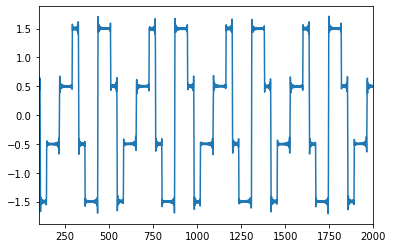

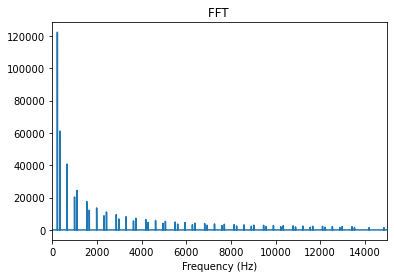

In [22]:
square_a = square(sr,duration,a,num_overtones,phase)
square_b = square(sr,duration,b,num_overtones,phase)
square_c = square_a + .5*square_b

square_fft = np.fft.fft(square_c)
plt.plot(square_c)
plt.xlim([100,2000])
plot_fft(np.abs(square_fft),0,15000,together='false')

In [23]:
square_processed = filter_by_scale3(square_c, 220, 'major', 2, sr)
square_processed_fft = square_processed[1]
square_filtered = square_processed[0]

<ipython-input-8-8ec8908dca1f>:54: ComplexWarning: Casting complex values to real discards the imaginary part
  phase_shifted_frequencies[k] = np.abs(z) * np.exp(delta_f * 1j * np.angle(z))


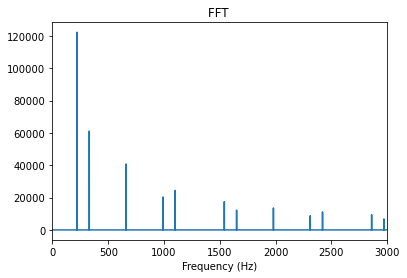

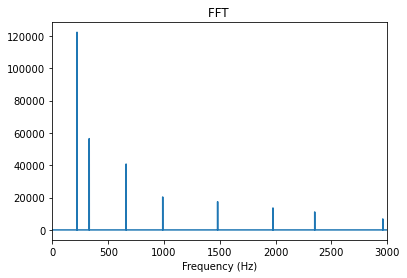

In [24]:
plot_fft(np.abs(square_fft),0,3000)
plot_fft(np.abs(square_processed_fft),0,3000,together='false')
display(Audio(square_c,rate = sr))
display(Audio(square_filtered,rate = sr))

In [62]:
guitar,sr = sf.read('em-asym-distortion-thing-Copy1.wav')

In [70]:
guitar_processed = filter_by_scale3(guitar[0:10000,0], 164.8, 'major triad', 2, sr)
guitar_processed_fft = guitar_processed[1]
guitar_filtered = guitar_processed[0]

[ 136.71  246.96  277.83  308.7   493.92  621.81  696.78  740.88 1243.62
 1481.76] [ 164.8  247.   247.   329.6  494.   659.2  659.2  659.2 1318.4 1318.4]


<ipython-input-61-8668c99a93ac>:54: ComplexWarning: Casting complex values to real discards the imaginary part
  phase_shifted_frequencies[k] = np.abs(z) * np.exp(delta_f * 1j * np.angle(z))


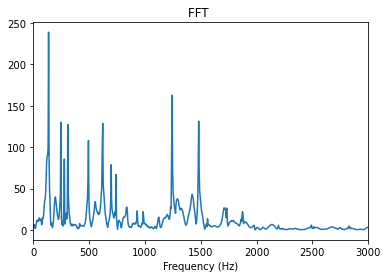

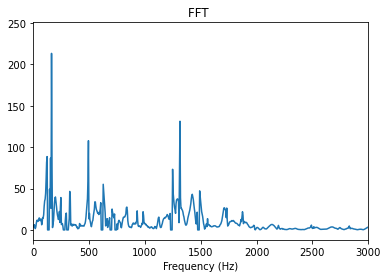

In [71]:
plot_fft(np.abs(np.fft.fft(guitar[0:10000,0])),0,3000)
plot_fft(np.abs(guitar_processed_fft),0,3000,together='false')
display(Audio(guitar[0:100000,0],rate = sr))
display(Audio(guitar_filtered,rate = sr))

In [ ]:
def stft(signal,fs):
    trial = sig.stft(signal,window='hann',nperseg=516,noverlap=256,padded=True)[2:]
    trial_fft = trial[0]
    
    first = trial_fft[:,0]
    plot_fft(np.abs(first))
    
    trial_fft[:,0] = filter_by_scale(first, 21.75, 'major triad', 1, sr)[1]
    plot_fft(np.abs(filter_by_scale(first, 21.75, 'major triad', 1, sr)[1]),together='false')
    
    print(np.shape(first))
    
    trialout = sig.istft(trial_fft,window='hann',nperseg=516,noverlap=256)
    display(Audio(signal,rate = sr))
    display(Audio(trialout[1],rate = sr))
    return

In [ ]:
def stft_processed(signal,fs):
    stft = sig.stft(signal,window='hann',nperseg=516,noverlap=516*3//4,padded=True)[2:]
    processed = stft[0]
    print(np.shape(processed))
    
    for i in range(len(processed[0,:])):
        frame = processed[:,i]
        filtered = filter_by_scale3(frame, 80, 'major triad', 1, fs)[1]
        
        
        if (i==300):
            plot_fft(frame)
            plot_fft(processed[:,i],together='false')
            print(frame==filtered)
        
    out = sig.istft(processed,window='hann',nperseg=516,noverlap=256)
    print('Input Signal:')
    display(Audio(signal,rate = sr))
    print('Output Signal')
    display(Audio(out[1],rate = sr))
    
    
    return

In [ ]:
def wstft(x, n_frame, n_hop, window):
    '''Compute a windowed short-time Fourier transform
    
    Parameters
    ----------
    x : the input signal (real-valued)
    
    n_frame : the frame length (in samples)
    
    n_hop : the hop length (in samples)
    
    window : a window specification
        e.g., "hann" or ("kaiser", 4.0)
        
        See scipy.signal.get_window for details
        
    Returns
    -------
    stft : the short-time fourier transform of x (complex-valued)
        Shape: (frame_count, 1 + n_hop // 2)
    '''
    
    # Compute the number of frames
    frame_count = 1 + (len(x) - n_frame) // n_hop
    
    # Initialize the output array
    # We have frame_count frames and (1 + n_frame//2) frequencies for each frame
    X = np.zeros((frame_count, 1 + n_frame // 2), dtype=np.complex)
    
    # We'll use scipy's window constructor here
    window = sig.get_window(window, n_frame)
    
    # Populate each frame's DFT results
    for k in range(frame_count):
        # Slice the k'th frame, apply a window, and take its DFT
        X[k, :] = np.fft.rfft(x[k * n_hop:k * n_hop + n_frame] * window)
#         if (k == 1):
#             print(len(X[k, :]))
        
    return X